# 1

I will be using using the ICE BofA US High Yield Index Effective Yield data from FRED. 

In [1]:
import pandas as pd
import numpy as np
from IPython.core.pylabtools import figsize
figsize(20, 5)
from fredapi import Fred
fred = Fred(api_key_file='FREDKEY.txt')

In [2]:
data_raw = fred.get_series('BAMLH0A0HYM2EY')

In [3]:
data = pd.DataFrame(data_raw).reset_index()
data.columns = ["Date", "Effective Yield %"]
data.head(3)

,Date,Effective Yield %
0,1996-12-31,9.55
1,1997-01-01,NaN
2,1997-01-02,9.57


In [4]:
data.tail(3)

,Date,Effective Yield %
6673,2022-04-01,5.86
6674,2022-04-04,5.80
6675,2022-04-05,5.88


There are NaN and dates missing. We will fill those in.


In [5]:
data = data.fillna(method = "ffill")
idx = pd.date_range('1996-12-31', '2022-04-05')
data = data.set_index("Date")
data.index = pd.DatetimeIndex(data.index)
data = data.reindex(idx, method = 'ffill')
data = data.reset_index()
data.columns = ["Date", "Effective Yield %"]

In [6]:
data.head(3)

,Date,Effective Yield %
0,1996-12-31,9.55
1,1997-01-01,9.55
2,1997-01-02,9.57


In [7]:
data.tail(3)

,Date,Effective Yield %
9224,2022-04-03,5.86
9225,2022-04-04,5.80
9226,2022-04-05,5.88


# 2

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

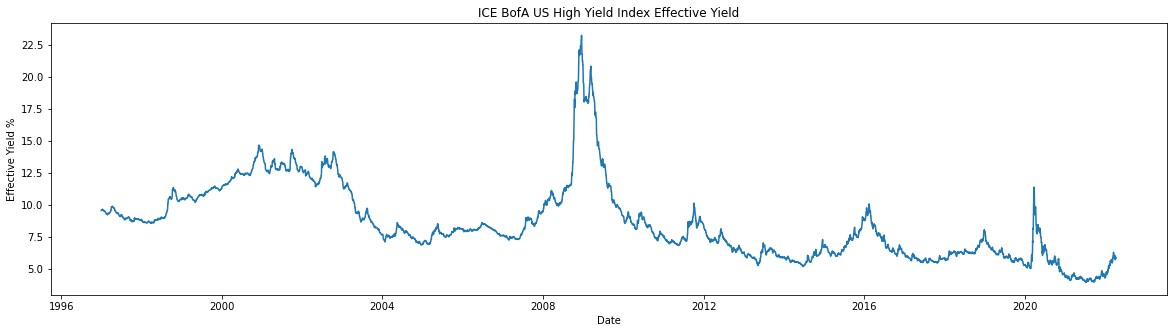

In [65]:
fig = sns.lineplot(x='Date', y="Effective Yield %", data=data).set(title = "ICE BofA US High Yield Index Effective Yield")
plt.show()

We can see from the graph above that the range is around 4 to 23, there is a large peak following the 2008 recession, and usually the line is mostly flat. Some of the upward spikes peak correlate with recessions such as 01, 08, and 2020, but there is also a spike in 2016 when the fed raised rates for the first time since the 08 recession. The effective yield around 2009 is the highest it's ever been and never went back to that level. It seems like recessions cause effective yields to increase and afterwards it trends towards prerecession levels. The covid pandemic caused a spike in effective yield, but it quickly came down again. Effective yield seems to be rising at the recent end.

# 3

In [10]:
import statsmodels.api as sm
from statsmodels.graphics import tsaplots

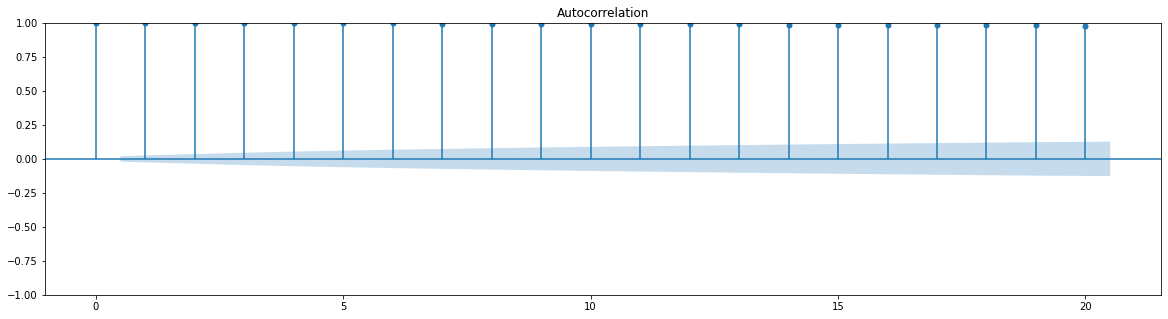

In [66]:
fig = tsaplots.plot_acf(data["Effective Yield %"], lags = 20)
plt.show()

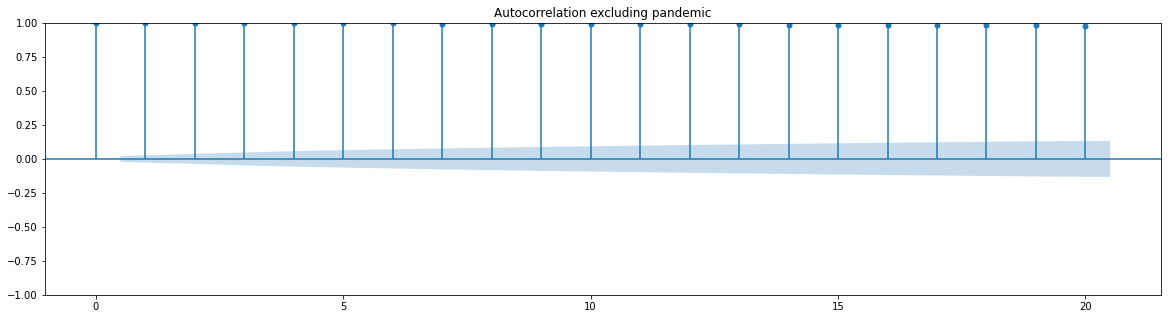

In [67]:
fig = tsaplots.plot_acf(data[data["Date"] <= "2019-12-31"]["Effective Yield %"], lags = 20, title = "Autocorrelation excluding pandemic")
plt.show()

The autocorrelation function isn't greatly impacted when including post 2020 data. So, we will use the full data set. 
Upon examining the graph, we see that the ACF is hovering very close to 1 for up to 20 lags. So, this means that the data is generally constant across periods. This matches what we see on the graph of the time series. 

# 4

In [13]:
#Credits to https://www.hackdeploy.com/augmented-dickey-fuller-test-in-python/
from statsmodels.tsa.stattools import adfuller
class StationarityTests:
    def __init__(self, significance=.05):
        self.SignificanceLevel = significance
        self.pValue = None
        self.isStationary = None
    def ADF_Stationarity_Test(self, timeseries, printResults = True, regression = 'ct'): #default is constant and trend;
        # statsmodel doesn't seem to have implemented a test for drift?
        #Dickey-Fuller test:
        adfTest = adfuller(timeseries, autolag='AIC', regression = regression) #Uses Akaike Information Criterion to choose lag
        
        self.pValue = adfTest[1]
        
        if (self.pValue<self.SignificanceLevel):
            self.isStationary = True
        else:
            self.isStationary = False
        
        if printResults:
            dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])

            #Add Critical Values
            for key,value in adfTest[4].items():
                dfResults['Critical Value (%s)'%key] = value

            print('Augmented Dickey-Fuller Test Results:')
            print(dfResults)

In [14]:
sTest = StationarityTests(significance = .05)
sTest.ADF_Stationarity_Test(data["Effective Yield %"], printResults = True, regression = 'ct') #testing for trend
print("Is the time series stationary? {0}".format(sTest.isStationary))

Augmented Dickey-Fuller Test Results:
ADF Test Statistic        -3.218288
P-Value                    0.080819
# Lags Used               35.000000
# Observations Used     9191.000000
Critical Value (1%)       -3.959755
Critical Value (5%)       -3.410968
Critical Value (10%)      -3.127331
dtype: float64
Is the time series stationary? False


I am considering a trend in the ADF test because it seems like overall effective yield has been declining. The p value is greater than .05 so I won't reject the null and effective yield is non-stationary. So, I should use the difference in effective yield from day to day going forward. 

# 5

In [15]:
data_diff = data.copy()
data_diff["diff_Effective Yield %"] = data["Effective Yield %"].diff(1)
data_diff = data_diff.dropna()
data_diff.head()

,Date,Effective Yield %,diff_Effective Yield %
1,1997-01-01,9.55,0.00
2,1997-01-02,9.57,0.02
3,1997-01-03,9.58,0.01
4,1997-01-04,9.58,0.00
5,1997-01-05,9.58,0.00


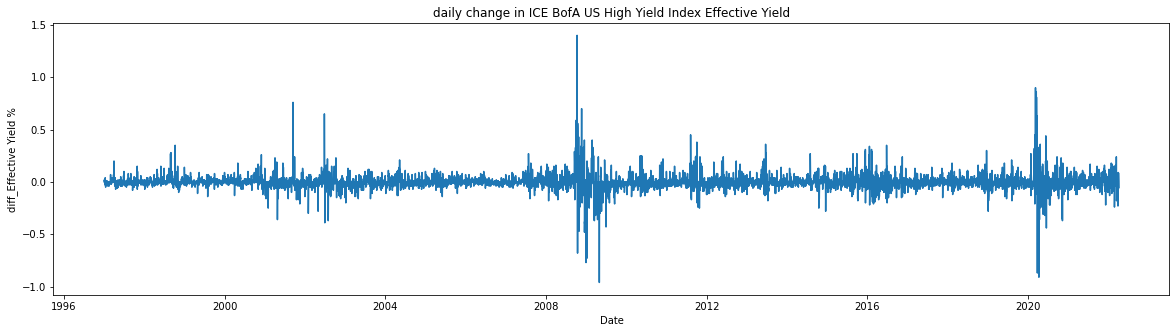

In [68]:
fig = sns.lineplot(x='Date', y="diff_Effective Yield %", data=data_diff).set(title = "daily change in ICE BofA US High Yield Index Effective Yield")
plt.show()

In [17]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error

In [18]:
model_1 = AutoReg(data_diff["diff_Effective Yield %"], lags = 1).fit()
print(model_1.bic)

-23912.012382969875


C:\Users\dxli2\anaconda3\envs\metrics\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [19]:
model_4 = AutoReg(data_diff["diff_Effective Yield %"], lags = 4).fit()
print(model_4.bic)

-23975.523265155625


C:\Users\dxli2\anaconda3\envs\metrics\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


We will choose an AR(4) model.

In [52]:
model_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              AutoReg Model Results                               
==================================================================================
Dep. Variable:     diff_Effective Yield %   No. Observations:                 9226
Model:                         AutoReg(4)   Log Likelihood               12015.150
Method:                   Conditional MLE   S.D. of innovations              0.066
Date:                    Thu, 07 Apr 2022   AIC                         -24018.299
Time:                            01:59:35   BIC                         -23975.523
Sample:                                 4   HQIC                        -24003.761
                                     9226                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -0.0002      0.001     -0.335      0.738      -0.002       0.001
diff_Effective Yield %.L1     0.2907      0.010     27.927      0.000       0.270       0.311
diff_Effective Yield %.L2     0.0232      0.011      2.143      0.032       0.002       0.044
diff_Effective Yield %.L3     0.0779      0.011      7.206      0.000       0.057       0.099
diff_Effective Yield %.L4     0.0308      0.010      2.957      0.003       0.010       0.051
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.5685           -0.0000j            1.5685           -0.0000
AR.2           -0.2108           -2.3637j            2.3730           -0.2642
AR.3           -0.2108           +2.3637j            2.3730            0.2642
AR.4           -3.6772           -0.0000j            3.6772           -0.5000
-----------------------------------------------------------------------------
"""

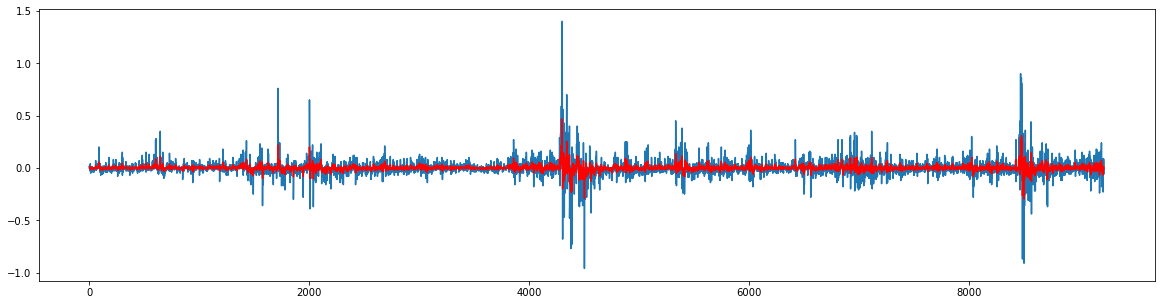

In [93]:
predictions = model_4.predict(start = 0, end = len(data_diff["diff_Effective Yield %"]) - 1, dynamic = False)
plt.plot(data_diff["diff_Effective Yield %"])
plt.plot(predictions, color = 'red')

The model fits the data relatively well. It generally follows the shape of the data, however it doesn't have as much variance as the data.

# 6

We will add the Federal Funds Effective Rate to the model.

In [22]:
data2_raw = fred.get_series('DFF', observation_start='1996-12-31')

In [23]:
data2 = pd.DataFrame(data2_raw).reset_index()
data2.columns = ["Date", "Fed Funds Rate %"]
data2 = data2.ffill()
sTest.ADF_Stationarity_Test(data2["Fed Funds Rate %"], printResults = True, regression = 'ct')
print("Is the time series stationary? {0}".format(sTest.isStationary))

Augmented Dickey-Fuller Test Results:
ADF Test Statistic        -1.284657
P-Value                    0.891671
# Lags Used               35.000000
# Observations Used     9191.000000
Critical Value (1%)       -3.959755
Critical Value (5%)       -3.410968
Critical Value (10%)      -3.127331
dtype: float64
Is the time series stationary? False


We will also use the daily change for the 10 Year yield.

In [24]:
data2_diff = data2.copy()
data2_diff["diff_Fed Funds Rate %"] = data2["Fed Funds Rate %"].diff(1)
data2_diff = data2_diff.dropna()
data2_diff.head(3)

,Date,Fed Funds Rate %,diff_Fed Funds Rate %
1,1997-01-01,6.26,0.00
2,1997-01-02,5.79,-0.47
3,1997-01-03,5.17,-0.62


In [25]:
data2_diff.tail(3)

,Date,Fed Funds Rate %,diff_Fed Funds Rate %
9224,2022-04-03,0.33,0.0
9225,2022-04-04,0.33,0.0
9226,2022-04-05,0.33,0.0


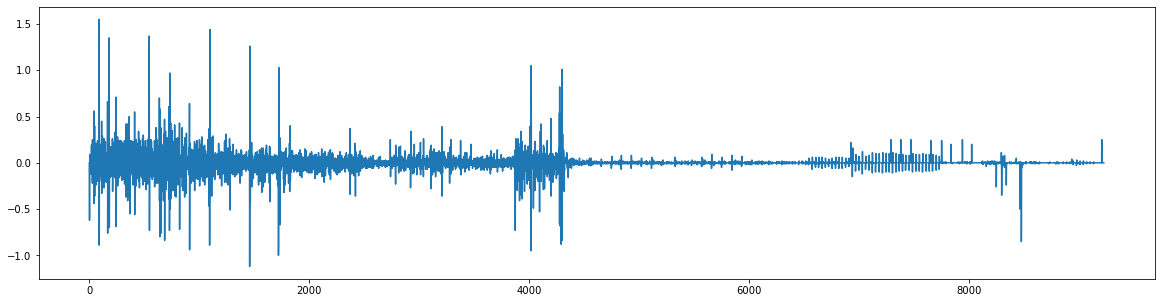

In [75]:
plt.plot(data2_diff["diff_Fed Funds Rate %"])

In [54]:
data3 = data_diff.merge(data2_diff, on = "Date")

In [123]:
data3.head()

,Date,Effective Yield %,diff_Effective Yield %,Fed Funds Rate %,diff_Fed Funds Rate %
0,1997-01-01,9.55,0.00,6.26,0.00
1,1997-01-02,9.57,0.02,5.79,-0.47
2,1997-01-03,9.58,0.01,5.17,-0.62
3,1997-01-04,9.58,0.00,5.17,0.00
4,1997-01-05,9.58,0.00,5.17,0.00


In [124]:
data3.tail()

,Date,Effective Yield %,diff_Effective Yield %,Fed Funds Rate %,diff_Fed Funds Rate %
9221,2022-04-01,5.86,0.07,0.33,0.0
9222,2022-04-02,5.86,0.00,0.33,0.0
9223,2022-04-03,5.86,0.00,0.33,0.0
9224,2022-04-04,5.80,-0.06,0.33,0.0
9225,2022-04-05,5.88,0.08,0.33,0.0


In [29]:
from statsmodels.tsa.api import ARDL

In [136]:
model_adl_4_1 = ARDL(data3["diff_Effective Yield %"].values, 4, data3[["diff_Fed Funds Rate %"]].values, 1).fit()

In [137]:
model_adl_4_1.bic

-23961.552115611117

In [60]:
model_adl_4_4 = ARDL(data3["diff_Effective Yield %"].values, 4, data3[["diff_Fed Funds Rate %"]].values, 4).fit()

In [139]:
model_adl_4_4.bic

-23951.30939598642

The ADL(4,1) is better.

In [140]:
model_adl_4_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARDL Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 9226
Model:                     ARDL(4, 1)   Log Likelihood               12017.293
Method:               Conditional MLE   S.D. of innovations              0.066
Date:                Thu, 07 Apr 2022   AIC                         -24018.587
Time:                        02:55:26   BIC                         -23961.552
Sample:                             4   HQIC                        -23999.203
                                 9226                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.001     -0.349      0.727      -0.002       0.001
y.L1           0.2906      0.010     27.910      0.000       0.270       0.311
y.L2           0.0227      0.011      2.095      0.036       0.001       0.044
y.L3           0.0780      0.011      7.209      0.000       0.057       0.099
y.L4           0.0308      0.010      2.956      0.003       0.010       0.051
x0.L0         -0.0158      0.008     -2.063      0.039      -0.031      -0.001
x0.L1         -0.0031      0.008     -0.406      0.685      -0.018       0.012
==============================================================================
"""

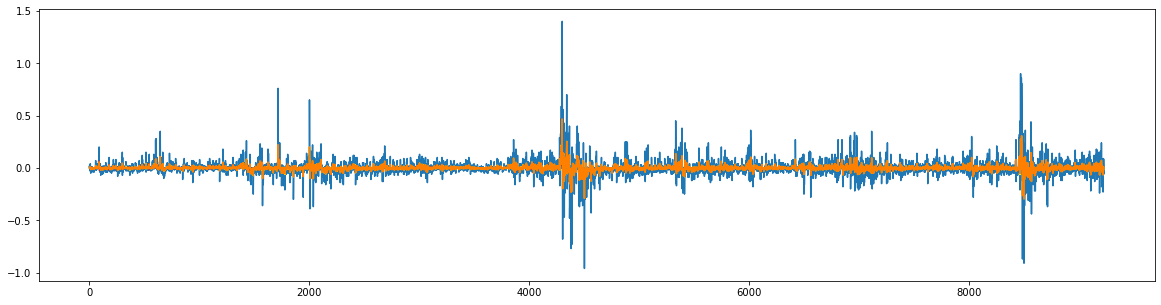

In [141]:
predictions2 = model_adl_4_1.predict(start = 0, end = len(data_diff["diff_Effective Yield %"]) - 1, dynamic = False)
plt.plot(data_diff["diff_Effective Yield %"])
plt.plot(predictions, color = 'yellow', alpha = 1)
plt.plot(predictions2, color = 'red', alpha = .5)

It seems that the ADL model and the AR model are almost the same as they overlap on the graph. If you look at the p-values of the coefficients of the fed fund rate, the first lag isn't even significant.

# 7

In [142]:
forecast_AR = float(model_4.predict(start = len(data3["diff_Effective Yield %"]), end = len(data3["diff_Effective Yield %"])).values)
print(forecast_AR)

0.021636974115552276


C:\Users\dxli2\anaconda3\envs\metrics\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [143]:
forecast_ADL = float(model_adl_4_1.predict(start = len(data3["diff_Effective Yield %"]), end = len(data3["diff_Effective Yield %"]), exog_oos = [0]))
print(forecast_ADL)

0.021652179698397413


# 8

In [111]:
#Python doesn't seem to give the in-sample SER, so I'll use sklearn's mse function
from sklearn.metrics import mean_squared_error
import math

In [127]:
t = 1.645

In [144]:
RMSE_AR = math.sqrt(mean_squared_error(data3["diff_Effective Yield %"].loc[4:9225], predictions.loc[4:9225]))
print(RSME_AR)

0.0657551369201067


In [145]:
print(f"90% CI_AR = ({forecast_AR-t*RSME_AR},{forecast_AR+t*RSME_AR})")

90% CI_AR = (-0.08653022611802325,0.1298041743491278)


In [146]:
RMSE_ADL = math.sqrt(mean_squared_error(data3["diff_Effective Yield %"].loc[4:9225], predictions2[4:]))
print(RSME_ADL)

0.06567877048316739


In [147]:
print(f"90% CI_ADL = ({forecast_ADL-t*RSME_ADL},{forecast_ADL+t*RSME_ADL})")

90% CI_ADL = (-0.08638939774641294,0.12969375714320777)
